In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# --- CONFIGURAÇÃO E LEITURA ---
# Caminho especificado por você
caminho_arquivo = r"C:\Users\angelo.medeiros\Documents\Violencia TIY\HGR-violencia-tiy.xlsx"

# Tenta ler como Excel. Se der erro de biblioteca ausente, avisa para instalar openpyxl
try:
    df = pd.read_excel(caminho_arquivo)
except ImportError:
    print("Erro: Instale a biblioteca openpyxl com: !pip install openpyxl")
except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado no caminho: {caminho_arquivo}")
    # Fallback para teste (caso esteja rodando sem o arquivo local)
    # df = pd.read_csv('seu_arquivo.csv') 

# --- PRÉ-PROCESSAMENTO (LIMPEZA) ---

# 1. Filtro: Apenas Sexo Feminino (F)
# O CSV mostra a coluna CS_SEXO
if 'CS_SEXO' in df.columns:
    df = df[df['CS_SEXO'].isin(['F', '2', 2])].copy()

# 2. Tratamento de Datas
cols_data = ['DT_NOTIFIC', 'DT_NASC', 'DT_OCOR']
for col in cols_data:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# 3. Cálculo Exato da Idade (Mais preciso que NU_IDADE_N)
# Baseado na diferença entre Data de Notificação e Data de Nascimento
df['IDADE_CALCULADA'] = (df['DT_NOTIFIC'] - df['DT_NASC']).dt.days // 365.25

# 4. Faixas Etárias (Questão 1.1 do documento)
bins = [0, 9, 19, 24, 59, 120]
labels = ['Criança (0-9)', 'Adolescente (10-19)', 'Jovem (20-24)', 'Adulta (25-59)', 'Idosa (60+)']
df['FAIXA_ETARIA'] = pd.cut(df['IDADE_CALCULADA'], bins=bins, labels=labels, right=True)

# 5. Mapeamento de Sim/Não (Padrão SINAN: 1=Sim, 2=Não, 9=Ignorado)
map_sinan = {1: 'Sim', 2: 'Não', 9: 'Ignorado', 3: 'Não se aplica', 8: 'Não se aplica'}

print("Dados carregados e tratados. Total de registros (Mulheres):", len(df))

Dados carregados e tratados. Total de registros (Mulheres): 195


--- Q0. Evolução Temporal ---


,Ano,Total de Casos
0,2019,24
1,2020,18
2,2021,24
3,2022,26
4,2023,68
5,2024,35


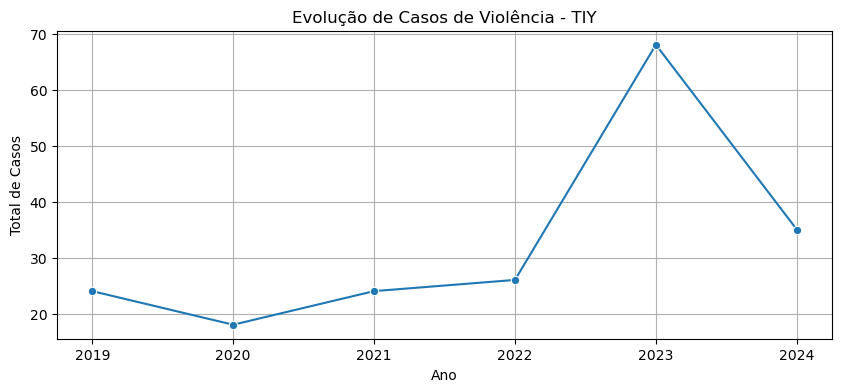

In [2]:
# Agrupando por Ano
df['ANO'] = df['DT_NOTIFIC'].dt.year
evolucao = df['ANO'].value_counts().sort_index().reset_index()
evolucao.columns = ['Ano', 'Total de Casos']

print("--- Q0. Evolução Temporal ---")
display(evolucao)

# Gráfico simples para visualização rápida
plt.figure(figsize=(10,4))
sns.lineplot(data=evolucao, x='Ano', y='Total de Casos', marker='o')
plt.title("Evolução de Casos de Violência - TIY")
plt.grid(True)
plt.show()

In [3]:
# Q1.1 Distribuição por Faixa Etária
dist_etaria = df['FAIXA_ETARIA'].value_counts().sort_index().reset_index()
dist_etaria.columns = ['Faixa Etária', 'Qtd']
dist_etaria['%'] = (dist_etaria['Qtd'] / len(df) * 100).round(1)

# Q1.2 Gestantes (CS_GESTANT: 1,2,3,4 = Grávida / 5 = Não / 6 = N/A / 9 = Ignorado)
# Vamos criar uma coluna binária para facilitar
def classifica_gestante(x):
    if x in [1, 2, 3, 4]: return 'Sim'
    elif x == 5: return 'Não'
    else: return 'Ignorado/NA'

df['GESTANTE_BIN'] = df['CS_GESTANT'].apply(classifica_gestante)
gestantes_por_faixa = pd.crosstab(df['FAIXA_ETARIA'], df['GESTANTE_BIN'])

# Q1.3 Situação Conjugal (SIT_CONJUG)
# Mapeamento comum SINAN: 1-Solteiro, 2-Casado, 3-Viuvo, 4-Separado, 8-N/A, 9-Ign
map_conjugal = {1: 'Solteira', 2: 'Casada/União', 3: 'Viúva', 4: 'Separada', 8: 'N/A', 9: 'Ignorado'}
df['SIT_CONJUG_DESC'] = df['SIT_CONJUG'].map(map_conjugal).fillna('Não Informado')
conjugal = df['SIT_CONJUG_DESC'].value_counts().reset_index()

# Q1.4 Transtorno Mental (TRAN_MENT: 1=Sim, 2=Não)
df['TRANSTORNO_DESC'] = df['TRAN_MENT'].map(map_sinan).fillna('Não Informado')
transtorno = df['TRANSTORNO_DESC'].value_counts()

print("--- Q1.1 Faixa Etária ---\n", dist_etaria)
print("\n--- Q1.2 Gestantes por Faixa Etária ---\n", gestantes_por_faixa)
print("\n--- Q1.3 Situação Conjugal ---\n", conjugal)

--- Q1.1 Faixa Etária ---
           Faixa Etária  Qtd     %
0        Criança (0-9)    0   0.0
1  Adolescente (10-19)   46  23.6
2        Jovem (20-24)   58  29.7
3       Adulta (25-59)   84  43.1
4          Idosa (60+)    7   3.6

--- Q1.2 Gestantes por Faixa Etária ---
 GESTANTE_BIN         Ignorado/NA  Não  Sim
FAIXA_ETARIA                              
Adolescente (10-19)            2   42    2
Jovem (20-24)                  1   53    4
Adulta (25-59)                 1   81    2
Idosa (60+)                    0    7    0

--- Q1.3 Situação Conjugal ---
   SIT_CONJUG_DESC  count
0    Casada/União     94
1        Solteira     60
2        Ignorado     37
3             N/A      4


In [4]:
# Q2.1 Tipos de Violência (Colunas BS a CC na tabela de referência, nomes no CSV)
cols_violencia = [
    'VIOL_FISIC', 'VIOL_PSICO', 'VIOL_TORT', 'VIOL_SEXU', 
    'VIOL_TRAF', 'VIOL_FINAN', 'VIOL_NEGLI', 'VIOL_INFAN', 
    'VIOL_LEGAL', 'VIOL_OUTR'
]

# Contar quantos '1' (Sim) existem em cada coluna
resumo_violencia = {}
for col in cols_violencia:
    if col in df.columns:
        qtd = len(df[df[col] == 1])
        resumo_violencia[col] = qtd

df_violencia = pd.DataFrame(list(resumo_violencia.items()), columns=['Tipo', 'Qtd']).sort_values('Qtd', ascending=False)

# Q2.3 Meio Utilizado (AG_FORCA, AG_ENFOR, AG_OBJETO, AG_CORTE, AG_QUENTE, AG_FOGO, AG_AMEACA)
cols_meio = [col for col in df.columns if col.startswith('AG_') and col != 'AG_OUTROS']
resumo_meio = {}
for col in cols_meio:
    if col in df.columns:
        qtd = len(df[df[col] == 1])
        resumo_meio[col] = qtd

df_meio = pd.DataFrame(list(resumo_meio.items()), columns=['Meio Agressão', 'Qtd']).sort_values('Qtd', ascending=False)

print("--- Q2.1 Tipos de Violência ---")
display(df_violencia)
print("\n--- Q2.3 Meios Utilizados ---")
display(df_meio)

--- Q2.1 Tipos de Violência ---


,Tipo,Qtd
0,VIOL_FISIC,189
9,VIOL_OUTR,4
1,VIOL_PSICO,2
3,VIOL_SEXU,2
2,VIOL_TORT,1
6,VIOL_NEGLI,1
4,VIOL_TRAF,0
5,VIOL_FINAN,0
7,VIOL_INFAN,0
8,VIOL_LEGAL,0



--- Q2.3 Meios Utilizados ---


,Meio Agressão,Qtd
0,AG_FORCA,103
2,AG_OBJETO,58
3,AG_CORTE,54
6,AG_FOGO,14
1,AG_ENFOR,4
7,AG_AMEACA,2
4,AG_QUENTE,1
5,AG_ENVEN,0
8,AG_ESPEC,0


In [5]:
# Q3.2 Vínculo (Colunas REL_...)
cols_vinculo = [col for col in df.columns if col.startswith('REL_') and col != 'REL_TRAB']
resumo_vinculo = {}
for col in cols_vinculo:
    if col in df.columns:
        qtd = len(df[df[col] == 1])
        resumo_vinculo[col] = qtd

df_vinculo = pd.DataFrame(list(resumo_vinculo.items()), columns=['Vínculo', 'Qtd']).sort_values('Qtd', ascending=False)

# Q3.3 Sexo do Autor (AUTOR_SEXO: 1=Masc, 2=Fem, 3=Ambos)
map_sexo_autor = {1: 'Masculino', 2: 'Feminino', 3: 'Ambos', 9: 'Ignorado'}
if 'AUTOR_SEXO' in df.columns:
    sexo_autor = df['AUTOR_SEXO'].map(map_sexo_autor).value_counts()
else:
    sexo_autor = "Coluna AUTOR_SEXO não encontrada"

# Q3.4 Uso de Álcool (AUTOR_ALCO: 1=Sim, 2=Não)
if 'AUTOR_ALCO' in df.columns:
    alcool_autor = df['AUTOR_ALCO'].map(map_sinan).value_counts()
else:
    alcool_autor = "Coluna AUTOR_ALCO não encontrada"

print("--- Q3.2 Vínculo com a Vítima ---")
display(df_vinculo)
print("\n--- Q3.3 Sexo do Autor ---\n", sexo_autor)
print("\n--- Q3.4 Suspeita de Uso de Álcool ---\n", alcool_autor)

--- Q3.2 Vínculo com a Vítima ---


,Vínculo,Qtd
4,REL_CONJ,59
11,REL_CONHEC,57
9,REL_DESCO,33
10,REL_IRMAO,6
16,REL_PROPRI,5
8,REL_FILHO,4
17,REL_OUTROS,2
6,REL_NAMO,2
1,REL_PAI,1
20,REL_MAD,1



--- Q3.3 Sexo do Autor ---
 AUTOR_SEXO
Masculino    93
Ignorado     46
Feminino     32
Ambos        24
Name: count, dtype: int64

--- Q3.4 Suspeita de Uso de Álcool ---
 AUTOR_ALCO
Sim         100
Ignorado     69
Não          25
Name: count, dtype: int64
